Shown in fig 5S2.

In [1]:
from common import colors, sbarlw

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [3]:
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from ezephys import pltools

from grr.Spiketrain import PSTH
from grr.Simulation import GIFnet_Simulation
from grr.Tools import reprint

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [5]:
def infer_gaba_condition(dir_name):
    regex_match = re.search(r'GABA_(.*)', dir_name)
    if regex_match is not None:
        condition = regex_match.groups()[-1]
    elif 'endocannabinoid' == dir_name:
        condition = 'endocannabinoid'
    else:
        raise ValueError('Unrecognized GABA condition {}'.format(dir_name))
    return condition

In [6]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'oscillation_input')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

network_models = [
    'DRN_subsample_base',
    'mPFC_base'
]

for network_model in network_models:
    for gaba_condition in os.listdir(os.path.join(DATA_PATH, network_model)):
        for fname in os.listdir(os.path.join(DATA_PATH, network_model, gaba_condition)):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                )
                sim_dict['Mod type'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(infer_gaba_condition(gaba_condition))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, network_model, gaba_condition, fname), 
                        mode = 'r'
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,mPFC,KO,base,[ser],0
1,mPFC,KO,base,[ser],1
2,mPFC,KO,base,[ser],2
3,mPFC,KO,base,[ser],3
4,mPFC,KO,base,[ser],4


In [7]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [8]:
with open(os.path.join(DATA_PATH, 'oscillation_input.dat'), 'rb') as f:
    model_input = pickle.load(f)
    f.close()

In [9]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 98.3%
Done!


In [10]:
def select_sample_dataset(dframe, circuit, condition, mod_type, rep_num):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type)
        & (dframe['Rep'] == rep_num), 
        'Model'
    ].item()

In [11]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type), 
        psth_type
    ].item()

In [12]:
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep,Principal PSTH,GABA PSTH
0,mPFC,KO,base,[ser],0,"[[1.5333333333333334, 1.5333333333333334, 1.53...",None
1,mPFC,KO,base,[ser],1,"[[1.3666666666666667, 1.3666666666666667, 1.36...",None
2,mPFC,KO,base,[ser],2,"[[1.9333333333333333, 1.9333333333333333, 1.93...",None
3,mPFC,KO,base,[ser],3,"[[1.5666666666666667, 1.5666666666666667, 1.56...",None
4,mPFC,KO,base,[ser],4,"[[1.5666666666666667, 1.5666666666666667, 1.56...",None


In [13]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Principal PSTH': [], 'GABA PSTH': []}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
        for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(np.array(
                sim_df.loc[
                    (sim_df['Circuit'] == circuit) 
                    & (sim_df['Condition'] == cond) 
                    & (sim_df['Mod type'] == modtype), 
                    'Principal PSTH'
                ].tolist()
            ))
            psth_dict['GABA PSTH'].append(np.array(
                sim_df.loc[
                    (sim_df['Circuit'] == circuit) 
                    & (sim_df['Condition'] == cond) 
                    & (sim_df['Mod type'] == modtype), 
                    'GABA PSTH'
                ].tolist()
            ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [14]:
def get_spike_times(spike_trains, dt):
    spike_trains = np.asarray(spike_trains)
    
    spike_times = []
    for train_ind in range(spike_trains.shape[0]):
        spk_indices = np.where(spike_trains[train_ind, :] > 0.5)[0]
        spike_times.append(spk_indices * dt)
    
    return spike_times

In [15]:
def set_spike_apex(voltage_traces, spike_apex):
    voltage_traces[voltage_traces == 0.] = spike_apex
    return voltage_traces

In [16]:
num_sample_neurons = 20

In [35]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0).ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0).ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'Principal PSTH')[0, 0, :]

In [50]:
def plot_linear_filter(time_support, filter_input, time_constant, filter_length=5000, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    filt = np.exp(-t_vec[:filter_length] / time_constant)
    filt = np.concatenate([np.zeros_like(filt), filt])
    
    ax.plot(time_support, np.convolve(filter_input, filt, mode='same'), **pltargs)

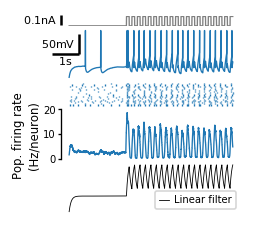

In [51]:
spec = gs.GridSpec(5, 1, height_ratios=[0.2, 1, 0.5, 1, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 2))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['ser'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['ser'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['ser'])
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.yticks([0, 10, 20])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

plt.subplot(spec[4, :])
plot_linear_filter(t_vec, model_input['ser_input'][0, 0, :], 0.0722, color='k', lw=0.5, label='Linear filter')
plt.legend()
pltools.hide_ticks()
pltools.hide_border()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_oscillation_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_oscillation_sample.svg'))

# SOM

In [52]:
num_sample_neurons = 20

In [53]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0).gaba_examples['V'][0, 5, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0).gaba_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'base', 'subsample_base', 'GABA PSTH')[0, 0, :]

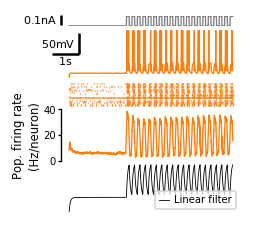

In [56]:
spec = gs.GridSpec(5, 1, height_ratios=[0.2, 1, 0.5, 1, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 2))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['gaba_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['som'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['som'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['som'])
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.yticks([0, 20, 40])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

plt.subplot(spec[4, :])
plot_linear_filter(t_vec, model_input['gaba_input'][0, 0, :], 0.0422, color='k', lw=0.5, label='Linear filter')
plt.legend(loc='lower right')
pltools.hide_ticks()
pltools.hide_border()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_population_oscillation_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_population_oscillation_sample.svg'))

# mPFC

In [57]:
num_sample_neurons = 20

In [58]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0).ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0).ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'Principal PSTH')[0, 0, :]

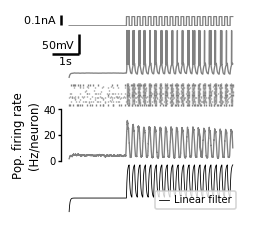

In [59]:
spec = gs.GridSpec(5, 1, height_ratios=[0.2, 1, 0.5, 1, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 2))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['pyr'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['pyr'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['pyr'])
plt.yticks([0, 20, 40])
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

plt.subplot(spec[4, :])
plot_linear_filter(t_vec, model_input['gaba_input'][0, 0, :], 0.0274, color='k', lw=0.5, label='Linear filter')
plt.legend(loc='lower right')
pltools.hide_ticks()
pltools.hide_border()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_oscillation_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_oscillation_sample.svg'))